# Fold arbitrary fluxes through MagEIS isotropic response functions

This notebook explores how to calculate flux as a function of energy. This method has the advantage that it does not depend on the spectral shape. 

The basic steps are: first create a fake true spectrum (exponential in this case, or hypothetically any other spectra). Then draw the observed counts from the true spectra. Next, we assume unifrom priors on the energy channel-dependent flux. This is where the "shape" kwarg comes in. This appears to be the best way (but perhaps not the only way) to create arrays of stocastic variables. Then we simply multiply the stocastic flux variables by their respective response functions to get counts. Lastly, we use MCMC to find the distribution of fluxes that best match the observed counts. 

TO-DO:
- Look into the unifrom prior assumption. Can we do better?
- Apply this algorithm to the MagEIS data to see how close these values are to the main rate data. Will need to use Seth's look up tables (LUTs) to determine which energy channels to use.
- Implement Brian's idea of using a histogram of fluxes with an arbitrary number of bins. Math question: Does having more flux bins than energy channels make any sense? It seems like we are interpolating and not gaining anything new from this.
- Lastly, I would like to use the Bayes factor to determine which spectra better fits the MagEIS data? Brian thinks there will be hardly any difference (|B factor| < 10ish) but who knows? If there are systematic trends, maybe a power law fits quiet time rad belt, while exponential fits interesting structures such as injections? Just a thought, but may be worth exploring to get at the underlying physics.

In [2]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.integrate
sns.set(font_scale=1.5)
%matplotlib inline
import sys

sys.path.append('../utils/')
import mageis_response

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/packages2/.packages2/x86_64-pc-linux-gnu-rhel7/python/3.6.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Create a true exponential spectra with E0t and J0t parameters. 
Then use that spectra and fold it through the MagEIS response functions to get true counts as a function of energy channel.

In [3]:
# Spectra parameters
E0t = 100 # keV
J0t = 1E4 # 1/(cm^2 sr s keV)

# Initialize the response function
R = mageis_response.R_iso(101) # RBSP-A MagEIS LOW.
E = R.E*1000 # energy array in keV.
n_ch = 9 # Use the main rate channels

# Define an exponential spectra.
def spectra(Earr, J0, E0):
    return(J0*np.exp(-Earr/E0))

# Now create the "true" counts drawn from the parent distribution. This assumes there
# is no uncertanity in the response functions.
true_lambda = np.array([scipy.integrate.trapz(spectra(E, J0t, E0t)*R.response(i), x=E)
                       for i in range(n_ch)])

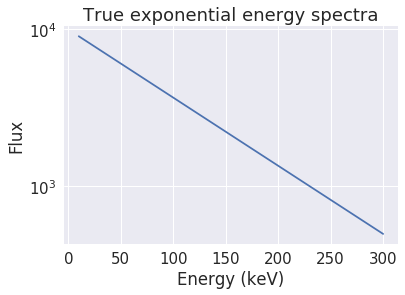

In [4]:
plt.plot(E, spectra(E, J0t, E0t)); plt.title('True exponential energy spectra')
plt.yscale('log'); plt.xlabel('Energy (keV)'); plt.ylabel('Flux');

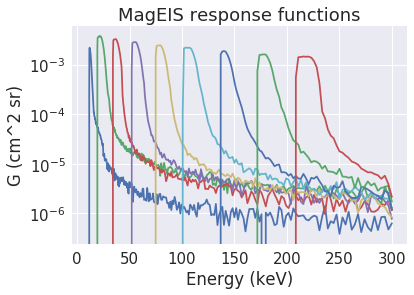

In [5]:
for i in range(n_ch):
    plt.plot(E, R.response(i), label='ch{}'.format(i));
plt.xlabel('Energy (keV)'); plt.ylabel('G (cm^2 sr)'); 
plt.title('MagEIS response functions'); plt.yscale('log');

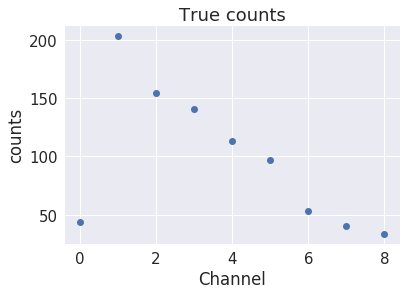

In [6]:
plt.plot(range(n_ch), true_lambda, 'o'); 
plt.ylabel('counts'); plt.xlabel('Channel'); plt.title('True counts');

Now draw observed counts from true_lambda assuming a Poisson process

In [7]:
np.random.seed(123)
c_obs = np.random.poisson(true_lambda)

In [8]:
# Define the energy channel boundaries for the spectra
nE = 20
E_bins = np.linspace(E[0], E[-1], num=nE+1)
istart = [np.where(E >= i)[0][0] for i in E_bins][:-1]
iend = [np.where(E <= i)[0][-1] for i in E_bins][1:]

### Model the energy channel-dependent flux 

In [22]:
def pymcTrapz(f, x):
    """
    This function is the pymc3 Trapz implementation for an uneven grid.
    It integrates a function f over an uneven grid x.
    """
    return 0.5*pm.math.dot((f[1:] + f[:-1]), (x[1:] - x[:-1]))

def lam(JJ):
    """
    This function appears to the only way to correctly work with pymc3 and 
    propagate the sampled spectra though the instrument response functions.
    """
    # Numpy arrays do not work for this, but lists can store anything (sloppy).
    lams = n_ch*[0] 
    
    for ch in range(n_ch):
        #f = pm.math.constant
        f = len(E)*[0]
        for ebin in range(nE):
            # Fold the flux through R
#             f[istart[i]:iend[i]] += pm.math.dot(JJ[ebin], response[istart[i]:iend[i], ch])
            f[istart[ebin]:iend[ebin]] += JJ[ebin]*R.response(ch)[istart[ebin]:iend[ebin]]
        # Integrate over the folded spectra and keep an MCMC trace.
        lams[ch] = pm.Deterministic('lam{}'.format(ch), pymcTrapz(f, E))
    return lams

m = pm.Model()
with m:
    # Prior stocastic variables
    J = pm.Uniform('J', lower=1, upper=1E6, shape=nE)

    lams = lam(J) # Get the count values from the picked J array of values.
    c_m = pm.Poisson('c_m', mu=lams, observed=c_obs, shape=len(c_obs))
    trace = pm.sample(1E4, tuning=1000, cores=3)

ValueError: length not known: Elemwise{add,no_inplace} [id A] ''   
 |TensorConstant{(119,) of 0} [id B]
 |Elemwise{mul,no_inplace} [id C] ''   
   |InplaceDimShuffle{x} [id D] ''   
   | |Subtensor{int64} [id E] ''   
   |   |ViewOp [id F] 'J'   
   |   | |Elemwise{add,no_inplace} [id G] ''   
   |   |   |Elemwise{mul,no_inplace} [id H] ''   
   |   |   | |InplaceDimShuffle{x} [id I] ''   
   |   |   | | |Elemwise{sub,no_inplace} [id J] ''   
   |   |   | |   |TensorConstant{1000000.0} [id K]
   |   |   | |   |TensorConstant{1.0} [id L]
   |   |   | |sigmoid [id M] ''   
   |   |   |   |J_interval__ [id N]
   |   |   |InplaceDimShuffle{x} [id O] ''   
   |   |     |TensorConstant{1.0} [id L]
   |   |Constant{0} [id P]
   |TensorConstant{[0.0000000..53070e-06]} [id Q]


In [ ]:
pm.traceplot(trace, combined=True);

In [ ]:
pm.summary(trace)

In [ ]:
for ch in range(n_ch):
    plt.hist(trace['J'][:, ch], alpha=0.7, bins=100, label='ch{}'.format(ch))
plt.legend(); plt.title('Flux traces'); plt.ylabel('#'); plt.xlabel('Flux');

Now use the traces to calculate the modeled counts and uncertainties, as well as the flux means and stds.

In [ ]:
c_mean = [np.mean(trace['lam{}'.format(i)]) for i in range(len(c_obs))]
c_std = [np.std(trace['lam{}'.format(i)]) for i in range(len(c_obs))]

j_mean = np.mean(trace['J'], axis=0)
j_std = np.std(trace['J'], axis=0)

c_Err = np.asarray([np.percentile(trace['lam{}'.format(i)], (2.5, 97.5)) 
                    for i in range(len(c_obs))])

In [ ]:
plt.plot(np.arange(n_ch), c_obs, 'go', label='observed counts', ms=10);
plt.errorbar(np.arange(n_ch), c_mean, fmt='ro', yerr=c_std, label='modeled counts', ms=5);
plt.legend(); plt.title('True vs modeled counts'); plt.xlabel('Energy channel');
plt.ylabel('Counts');

In [ ]:
plt.errorbar(np.arange(n_ch), j_mean, fmt='ro', yerr=j_std, label='modeled flux', ms=5);
plt.title('Modeled flux'); plt.xlabel('Energy channel'); plt.ylabel('Flux');
plt.yscale('log')

In [ ]:
#pm.plots.pairplot(trace);

### Now try to fit the flux to recover the exponential fit parameters

In [ ]:
# Find the representative energy channel middles.
E_mid = np.argmax([R.response(i) for i in range(n_ch)], axis=1)

In [ ]:
E_mid

Now fit log(J) with a straight line

In [ ]:
p = np.polyfit(E_mid, np.log(j_mean), 1)
print('Fit values: \nJ0 = {} [flux units], E0 = {} keV'.format(round(np.exp(p[1])), round(-1/p[0])))
print('True values: \nJ0 = {} [flux units], E0 = {} keV'.format(round(J0t), round(E0t)))
print('Relative error: JOerr = {} %, E0err = {} %'.format(
        round(100*(1-np.exp(p[1])/J0t)),
        round(100*(1+1/p[0]/E0t))))

In [ ]:
plt.errorbar(E_mid, j_mean, fmt='ro', yerr=j_std, label='modeled flux', ms=5);
# plt.plot(p[1]*np.exp(E/p[0])); #plt.yscale('log')
plt.plot(E, np.exp(p[1])*np.exp(p[0]*E));
plt.yscale('log'); plt.title('Model and fit flux'); 
plt.xlabel('Energy (keV)'); plt.ylabel('Flux');

This seems like a fairly terrible fit while the fit parameters are not crazy wrong. This way it is diffult to get at the errors.

Lessons learned: By blindly fitting the flux spectra, J0 was off by ~40% while E0 was off by ~25%. What is worse is that we do not have a good way to get at the errors using this approach.